# <center> Dam Break Test Case </center>
## <center> SPH Project </center>
### <center> Free surface detector </center>

<center> Based on the work of Rémi Carmigniani et Damien Violeau </center>
<center> Density diffusion added by Ludovic Druette and Théo Contentin </center>

In [7]:
%load_ext autoreload
%autoreload 2
import numpy as np
from sys import exit
import os.path
from os import path
import csv
import time
import matplotlib
import matplotlib.pyplot as plt
from src.spyh import *
from src.sphvar import *
from src.plotParticles import *
from src.state import *
from src.contrib import *
from src.freeSurface import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


SyntaxError: invalid decimal literal (freeSurface.py, line 28)

In [ ]:
current_directory = os.getcwd()
results_directory = os.path.join(current_directory, r'Results')
try:
    os.mkdir(results_directory)
except FileExistsError:
    pass

case_directory = os.path.join(results_directory, r'FreeSurface_'+time.strftime("%Y%m%d_%H%M%S"))
os.mkdir(case_directory)
data_directory = os.path.join(case_directory,r'Data')
figures_directory = os.path.join(case_directory,r'Figures')
os.mkdir(data_directory)
os.mkdir(figures_directory)

In [ ]:
import scipy.io as sio
validation = sio.loadmat('.dam_break/validation/Data_Table_Martin_1952_n2_2.mat')

In [ ]:
#FLUID PARAMETERS
rhoF = 1000
c0 = 40
gamma = 7
B = rhoF*c0**2/gamma
grav = np.array([0,-9.81]) 
#ARTIFICIAL VISCOSITY (voir plus loin)
alpha = 0.3
esp=10**(-6) #and it is multiplied by dr**2 in the code
#DENSITY DIFFUSION
densityDiffusion = True
delta = 0.2
#DENSITY & SHEPARD THRESHOLDS : 
shepardMin = 10**(-6)
rhoMin = 0.5*rhoF
rhoMax = 1.5*rhoF
#GEOMETRY
Lx = 2
Ly = 2
lx = 0.5
ly=1

In [2]:
#PARTICLES & SPACES PARAMETERS : 
dr = ly/30

NameError: name 'ly' is not defined

In [3]:
h = smthfc*dr
m=dr*dr*rhoF
lspace = 2*h
#COMPUTATION DOMAIN : 
xOrigin = -nBound*dr
yOrigin = -nBound*dr
xSize = Lx+2*nBound*dr
ySize = Ly+2*nBound*dr
xMax = xOrigin+xSize
yMax = yOrigin+ySize
#INIT SPACES & PART:
posSpace,neibSpace,partSpace,listNeibSpace = \
init_spaces(xOrigin,yOrigin,xSize,ySize,lspace,dr)
part = init_particles()
part = addBox(part,[lx,ly],FLUID,dr,rhoF)
part = addBox(part,[-nBound*dr,-nBound*dr,Lx+2*nBound*dr,nBound*dr],BOUND,dr,rhoF)
part = addBox(part,[-nBound*dr,0,nBound*dr,Ly],BOUND,dr,rhoF)
part = addBox(part,[Lx,0,nBound*dr,Ly],BOUND,dr,rhoF)
part,partSpace = sortPart(part,posSpace,partSpace,xOrigin,yOrigin,xSize,ySize,lspace,dr)
listNeibSpace= getListNeib(partSpace,neibSpace,listNeibSpace)

NameError: name 'dr' is not defined

In [4]:
#time, iteration count and im_count
t = 0
it=0
im_count=0
#Prepare table to compare with experiments
simvaluesTHX = np.empty((0,3),float)
Hmax = np.max(part[part[:,INFO]==FLUID,POS[1]])+dr*0.5
Xmax = np.max(part[part[:,INFO]==FLUID,POS[0]])+dr*0.5
simvaluesTHX= np.append(simvaluesTHX,[[t,Hmax,Xmax]],axis=0)
# Here we specify the output frequencies
dt_figure = 2./100.*(ly/np.linalg.norm(grav))**.5
t_print = 0
#final time :
t_end = 10

NameError: name 'part' is not defined

<IPython.core.display.Javascript object>


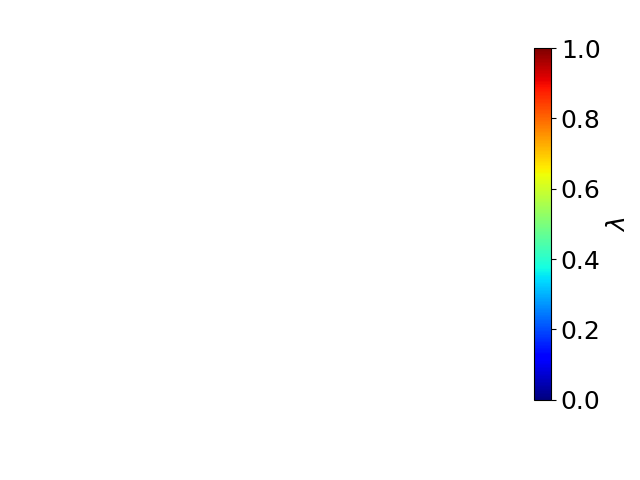

<IPython.core.display.Javascript object>


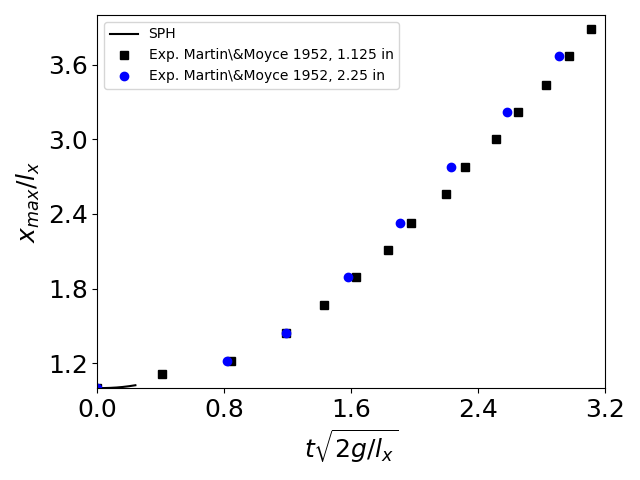

<IPython.core.display.Javascript object>


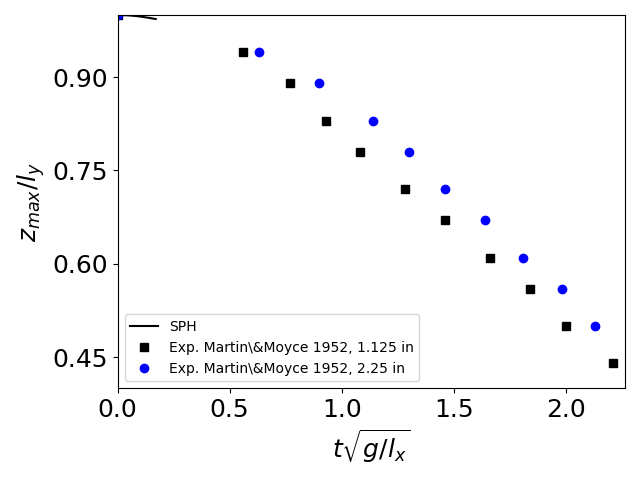

KeyboardInterrupt: 

In [8]:
%matplotlib notebook
while t<t_end:
    #STEP1 : Calcul de la CFL
    dt = CFLConditions(part[:,VEL],h,c0,grav)
    #STEP2 : Interpolation des conditions au bord
    part[:,RHO],part[:,VEL] =interpolateBoundary((part[:,INFO]==BOUND),\
                                     part[:,SPID],\
                                     part[:,POS],\
                                     part[:,VEL],\
                                     part[:,RHO],\
                                     listNeibSpace,\
                                 aW,h,m,B,rhoF,gamma,grav,shepardMin)
    #STEP3 : Calcul des forces et des termes de densité
    part[:,FORCES],part[:,DRHODT] = computeForcesART((part[:,INFO]==FLUID),\
                                                 part[:,SPID],\
                                                 part[:,POS],\
                                                 part[:,VEL],\
                                                 part[:,RHO],\
                                                 listNeibSpace,\
                                                 aW,h,m,B,rhoF,gamma,grav,alpha,esp,dr,\
                                                 c0,delta, densityDiffusion=densityDiffusion)
    #STEP4 : Integration en temps
    part[:,POS],part[:,VEL],part[:,RHO] = integrationStep((part[:,INFO]==FLUID),\
                                                       part[:,POS],\
                                                       part[:,VEL],\
                                                       part[:,RHO],\
                                                       part[:,FORCES],\
                                                       part[:,DRHODT],\
                                                     dt)
    #STEP5 : Corriger densité trop basse
    part[:,RHO] = checkDensity(part[:,RHO],rhoMin,rhoMax)
    #STEP6 : Mise à jour des voisins (pas forcément à tous les pas de temps)
    part,partSpace = sortPart(part,posSpace,partSpace,xOrigin,yOrigin,xSize,ySize,lspace,dr)
    listNeibSpace= getListNeib(partSpace,neibSpace,listNeibSpace)
    t +=dt
    it +=1
    if t>=t_print:
        fig = plt.figure(1)
        plt.clf()
        plt.title(r'$t*\sqrt{\frac{g}{H}} = %2.2f$'%(t*(np.linalg.norm(grav)/ly)**.5))
        velMagn = (part[:,VEL[0]]*part[:,VEL[0]]+part[:,VEL[1]]*part[:,VEL[1]])**.5/(ly*np.linalg.norm(grav))**.5
        # Free surface computation
        lambdas, isolatedPart, freeSurfacePart = freeSurfaceDetection(\
            part[:,INFO]==FLUID,\
            part[:,SPID],\
            part[:,POS],\
            part[:,RHO],\
            listNeibSpace,\
            aW,\
            h,\
            m)
        domain = [xOrigin,xMax,yOrigin,yMax,0,1]
        plotPropertiesWithBound(part,lambdas,r'$\lambda$',domain,dr,1)
        particleOutline(part, freeSurfacePart, 'black', dr, fig)
        figname = os.path.join(figures_directory,r'lambda_%06d.png'%im_count)
        im_count = im_count+1
        fig.savefig(figname,bbox_inches='tight')
        fig.canvas.draw()
        plt.pause(0.01)
        #extract front
        Hmax = np.max(part[part[:,INFO]==FLUID,POS[1]])+dr*0.5
        Xmax = np.max(part[part[:,INFO]==FLUID,POS[0]])+dr*0.5
        simvaluesTHX= np.append(simvaluesTHX,[[t,Hmax,Xmax]],axis=0)
        #plot figure of t and Xmax
        fig = plt.figure(2)
        plt.clf()
        plt.plot(simvaluesTHX[:,0]*(2*np.linalg.norm(grav)/lx)**.5,simvaluesTHX[:,2]/lx,'-k',label=r'SPH')
        plt.plot(validation["damb2ZT"][:,1],validation["damb2ZT"][:,0],'ks', label=r'Exp. Martin\&Moyce 1952, 1.125 in')       
        plt.plot(validation["damb1ZT"][:,1],validation["damb1ZT"][:,0],'bo',label = r'Exp. Martin\&Moyce 1952, 2.25 in')
        plt.xlabel('$t\sqrt{2g/l_x}$',fontsize=18)
        plt.ylabel('$x_{max}/l_x$',fontsize=18)
        plt.xlim(0,3.2)
        plt.ylim(1,4) 
        ax = plt.gca()
        ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
        ax.xaxis.set_major_locator(plt.MaxNLocator(5))
        ax.yaxis.set_major_locator(plt.MaxNLocator(5))
        plt.legend(loc='upper left')
        plt.tight_layout()
        plt.show(block=False)
        plt.draw()
        figname = os.path.join(case_directory,r'graph_xt.pdf')
        fig.savefig(figname,bbox_inches='tight')
        fig.canvas.draw()
        plt.pause(0.01)
        #plot figure of t and Hmax
        fig = plt.figure(3)
        plt.clf()
        plt.plot(simvaluesTHX[:,0]*(np.linalg.norm(grav)/lx)**.5,simvaluesTHX[:,1]/ly,'-k',label=r'SPH')
        plt.plot(validation["damb2HT"][:,1],validation["damb2HT"][:,0],'ks',label=r'Exp. Martin\&Moyce 1952, 1.125 in')           
        plt.plot(validation["damb1HT"][:,1],validation["damb1HT"][:,0],'bo',label =r'Exp. Martin\&Moyce 1952, 2.25 in')
        plt.xlabel('$t\sqrt{g/l_x}$',fontsize=18)
        plt.ylabel('$z_{max}/l_y$',fontsize=18)
        plt.xlim(0,3.2/2**.5)
        plt.ylim(0.4,1) 
        ax = plt.gca()
        ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
        ax.xaxis.set_major_locator(plt.MaxNLocator(5))
        ax.yaxis.set_major_locator(plt.MaxNLocator(5))
        plt.legend(loc='lower left')
        plt.tight_layout()
        plt.show(block=False)
        plt.draw()
        figname = os.path.join(case_directory,r'graph_ht.pdf')
        fig.savefig(figname,bbox_inches='tight')
        fig.canvas.draw()
        plt.pause(0.01)
        t_print = t_print+dt_figure

In [6]:
dr

NameError: name 'dr' is not defined